# Project # 4
## Overview:

## Objective: Build a model to classify images into different categories

### Description:
The project leverages a labeled dataset of images, such as CIFAR-10, which includes a diverse set of images categorized into different classes (e.g., airplanes, cars, birds, etc.). The goal is to train a convolutional neural network (CNN) that can effectively learn the features of each category and subsequently classify unseen images into their respective classes.

### Dataset:

The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset is a widely used benchmark in the field of computer vision. It consists of 60,000 images, each of size 32x32 pixels, divided across 10 different categories. Each class contains 6,000 images, covering various objects such as airplanes, automobiles, birds, cats, etc.

This dataset serves as a standard for image classification challenges, where the primary objective is to develop a model that can accurately classify images into their respective categories after being trained on a subset of the data.

In [3]:
import tensorflow as tf
# Import essential libraries for the project
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Sequential


### Loading and Preparing the CIFAR-10 Dataset


In [2]:
# Load the CIFAR-10 dataset directly from the Keras library
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


### Inspecting the Dataset

In [3]:
# Display the shape of the dataset to understand its structure
print(f"X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}\ny_train shape: {y_train.shape}\ny_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)


From the output, we observe that the dataset consists of 50,000 training images, each with dimensions of 32x32 pixels and 3 color channels (RGB). The test set contains 10,000 images. The labels for both training and testing sets are organized in single-column arrays.

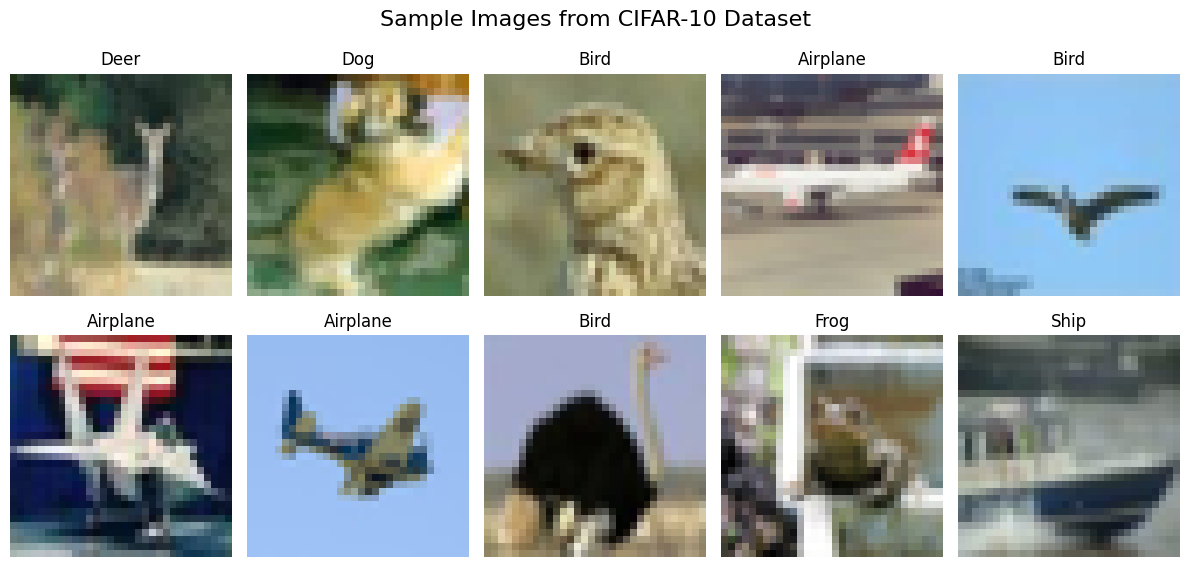

In [2]:
# Define class labels for CIFAR-10
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

# Plot some sample images with their labels
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("Sample Images from CIFAR-10 Dataset", fontsize=16)

for i, ax in enumerate(axes.flat):
    # Select a random image and its label
    idx = np.random.randint(0, X_train.shape[0])
    image = X_train[idx]
    label = class_names[y_train[idx][0]]
    
    # Display the image
    ax.imshow(image)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Image Preprocessing

In this section, we'll prepare the images and labels for the Convolutional Neural Network (CNN). Since the model performs multi-class classification, it's essential to convert the class labels into one-hot encoded vectors. This encoding converts the labels into a format that the CNN can effectively use for learning.

In [4]:
# Convert labels to one-hot encoded vectors for multi-class classification
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

To enhance the model's generalization ability and prevent overfitting, we'll apply data augmentation techniques. These transformations will diversify the training data by slightly altering the images, such as scaling, shearing, zooming, and flipping them horizontally.

The following transformations are applied to the training images:

- Rescaling pixel values to the [0, 1] range.
- Randomly applying shear transformations.
- Randomly applying zoom transformations.
- Randomly flipping images horizontally.

In [5]:
# Define the ImageDataGenerator for augmenting training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Generate augmented training data in batches
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=32
)


For the testing images, only pixel scaling is applied to avoid any data leakage and ensure the model's performance is evaluated on unaltered images.

In [6]:
# Define the ImageDataGenerator for the testing images with only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate testing data in batches
test_generator = test_datagen.flow(
    X_test, y_test,
    batch_size=32
)


## Constructing the CNN Model
### Model Initialization

In [7]:
# Start by initializing the Sequential model for the CNN architecture
cnn_model = Sequential()


### Input Layer
The model begins with an input layer, which is set to accept images with dimensions of 32x32 pixels and 3 color channels (RGB).

In [8]:
# Define the input layer
cnn_model.add(Input(shape=(32, 32, 3)))


### Convolutional Layers
The model incorporates two convolutional layers, each followed by a max pooling layer. The first convolutional layer extracts basic features from the images, while the second one, with a higher number of filters, captures more intricate patterns. Max pooling layers are utilized to downsample the feature maps, reducing their dimensions and helping prevent overfitting by introducing a degree of translational invariance.

In [9]:
# First convolutional layer with 32 filters and a 3x3 kernel
cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu"))
# First max pooling layer with a 2x2 pool size
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

# Second convolutional layer with 64 filters and a 3x3 kernel
cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation="relu"))
# Second max pooling layer with a 2x2 pool size
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))


### Flattening Layer
The output from the convolutional layers is flattened into a one-dimensional array, making it compatible for input into the subsequent fully connected layers.

In [10]:
# Flatten the output from the convolutional layers
cnn_model.add(Flatten())


### Fully Connected Layers
After flattening, the data passes through dense layers that perform the classification task. The first dense layer learns high-level features, followed by a second dense layer that further refines these features.

In [11]:
# First dense layer with 128 units
cnn_model.add(Dense(units=128, activation="relu"))
# Second dense layer with 64 units
cnn_model.add(Dense(units=64, activation="relu"))


### Output Layer
Finally, the output layer consists of 10 units corresponding to the 10 classes in the dataset. A softmax activation function is used to generate a probability distribution over the classes.

In [12]:
# Output layer with 10 units (one for each class) using softmax activation
cnn_model.add(Dense(units=10, activation="softmax"))


## Training the CNN Model
### Model Compilation
Before training, the CNN model needs to be compiled. This step involves specifying the optimizer, loss function, and evaluation metrics. The Adam optimizer is chosen for its adaptive learning rate capabilities. The categorical cross-entropy loss function is appropriate for multi-class classification tasks, and various performance metrics such as accuracy, precision, recall, and F1 score are included to evaluate the model comprehensively.

In [13]:
# Compile the model with the Adam optimizer and categorical cross-entropy loss
cnn_model.compile(optimizer="adam", 
                  loss="categorical_crossentropy", 
                  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


### Model Training
Now, the model is ready for training. The fit function is used to train the model on the augmented training data generated earlier. The model will be trained for 10 epochs, and its performance will be validated using the test data after each epoch.

In [14]:
# Train the CNN model on the augmented dataset with 10 epochs
history = cnn_model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)


Epoch 1/10


c:\Users\Naveed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.3774 - loss: 1.7117 - precision: 0.6433 - recall: 0.1389 - val_accuracy: 0.5698 - val_loss: 1.1968 - val_precision: 0.7116 - val_recall: 0.4231
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5816 - loss: 1.1932 - precision: 0.7417 - recall: 0.4076 - val_accuracy: 0.6220 - val_loss: 1.0634 - val_precision: 0.7447 - val_recall: 0.4962
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.6342 - loss: 1.0430 - precision: 0.7686 - recall: 0.5000 - val_accuracy: 0.6540 - val_loss: 1.0151 - val_precision: 0.7512 - val_recall: 0.5495
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.6603 - loss: 0.9662 - precision: 0.7789 - recall: 0.5425 - val_accuracy: 0.6715 - val_loss: 0.9583 - val_precision: 0.7690 - val_recall: 0.5771
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.6842 - loss: 0.8984 - precision: 0.7956 - recall: 0.5781 - val_accuracy: 0.6771 - val

## Conclusion
By the end of the training, the model demonstrates satisfactory performance with continuous improvements across all metrics. This indicates that the CNN has effectively learned to classify images from the CIFAR-10 dataset. The precision and recall values also suggest a well-balanced model, capable of generalizing well to new data.